# Sesión 9 — Autoencoders 

En esta sesión construiremos un **autoencoder** para aprender una representación (espacio latente) **sin etiquetas**.

**Objetivos**
- Entender la arquitectura **Encoder → Latente → Decoder**
- Entrenar con **pérdida de reconstrucción**
- Visualizar reconstrucciones y el **espacio latente**

Pregunta guía: **Si la red solo intenta reconstruir, ¿qué está aprendiendo realmente?**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [4]:
# Cargar dataset (MNIST)
# Nota: MNIST se usa porque es pequeño y permite visualizar reconstrucciones fácilmente.

try:
    from torchvision import datasets, transforms
    tfm = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
except Exception as e:
    raise RuntimeError(
        "No pude importar torchvision/MNIST. Instala torchvision o usa un entorno con torchvision disponible.\n"
        f"Error: {e}"
    )

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


100.0%
100.0%
100.0%
100.0%


(60000, 10000)

/home/cesar/teaching/Python-ML/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


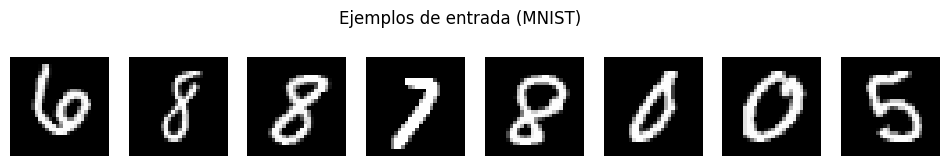

In [5]:
# Visualizar algunas imágenes
x, y = next(iter(train_loader))   # y existe, pero NO lo usaremos para entrenar
x = x[:8]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(x[i,0], cmap="gray")
    ax.axis("off")
plt.suptitle("Ejemplos de entrada (MNIST)")
plt.show()

# Pregunta: ¿Qué detalles necesitas conservar para poder reconstruir un dígito?


## Modelo: Autoencoder con cuello de botella

Para poder **visualizar** el espacio latente, usaremos `latent_dim = 2`.

- Encoder: aplana imagen (28×28) y la comprime a 2 números
- Decoder: expande esos 2 números de vuelta a 28×28


In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),  # MNIST en [0,1]
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        xhat = self.decoder(z)
        return xhat.view(-1, 1, 28, 28)

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        return xhat, z

model = Autoencoder(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Usaremos MSE; también podrías usar BCE para datos binarios.
criterion = nn.MSELoss()

sum(p.numel() for p in model.parameters())


435858

In [7]:
def train_epoch(model, loader):
    model.train()
    total = 0.0
    n = 0
    for x, _ in loader:  # ignoramos etiquetas
        x = x.to(device)
        optimizer.zero_grad()
        xhat, _ = model(x)
        loss = criterion(xhat, x)
        loss.backward()
        optimizer.step()
        total += loss.item() * x.size(0)
        n += x.size(0)
    return total / n

def eval_epoch(model, loader):
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            xhat, _ = model(x)
            loss = criterion(xhat, x)
            total += loss.item() * x.size(0)
            n += x.size(0)
    return total / n

train_losses = []
test_losses = []

epochs = 5
for ep in range(1, epochs+1):
    tr = train_epoch(model, train_loader)
    te = eval_epoch(model, test_loader)
    train_losses.append(tr)
    test_losses.append(te)
    print(f"Epoch {ep:02d} | train={tr:.4f} | test={te:.4f}")


Epoch 01 | train=0.0696 | test=0.0542
Epoch 02 | train=0.0523 | test=0.0509
Epoch 03 | train=0.0487 | test=0.0472
Epoch 04 | train=0.0458 | test=0.0450
Epoch 05 | train=0.0442 | test=0.0438


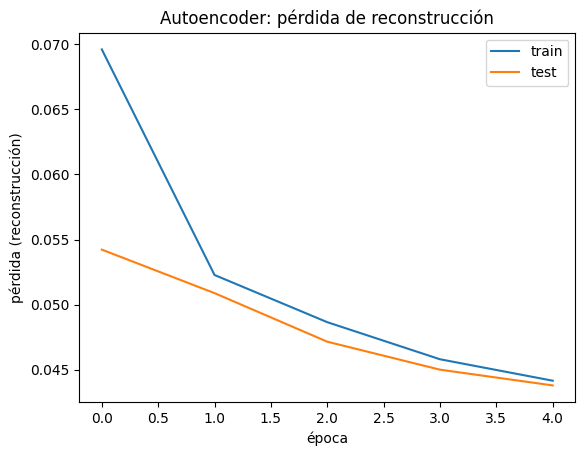

In [ ]:
# Curva de pérdida de reconstrucción
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("época")
plt.ylabel("pérdida (reconstrucción)")
plt.title("Autoencoder: pérdida de reconstrucción")
plt.legend()
plt.show()



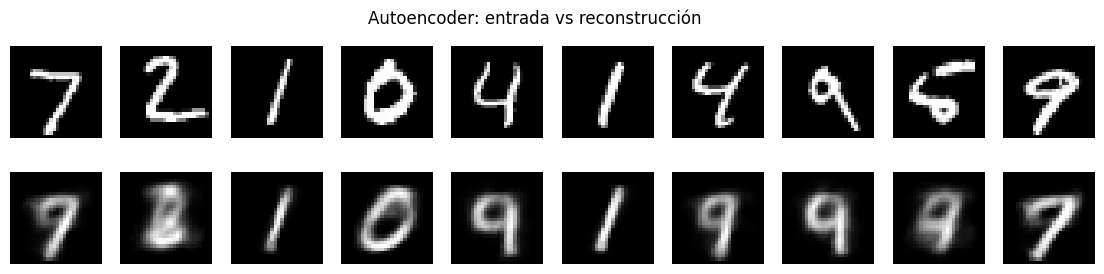

In [ ]:
# Reconstrucciones
model.eval()
x, _ = next(iter(test_loader))
x = x[:10].to(device)

with torch.no_grad():
    xhat, z = model(x)

x = x.cpu()
xhat = xhat.cpu()

fig, axes = plt.subplots(2, 10, figsize=(14, 3))
for i in range(10):
    axes[0, i].imshow(x[i,0], cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(xhat[i,0], cmap="gray")
    axes[1, i].axis("off")

axes[0,0].set_ylabel("entrada")
axes[1,0].set_ylabel("reconstr.")
plt.suptitle("Autoencoder: entrada vs reconstrucción")
plt.show()



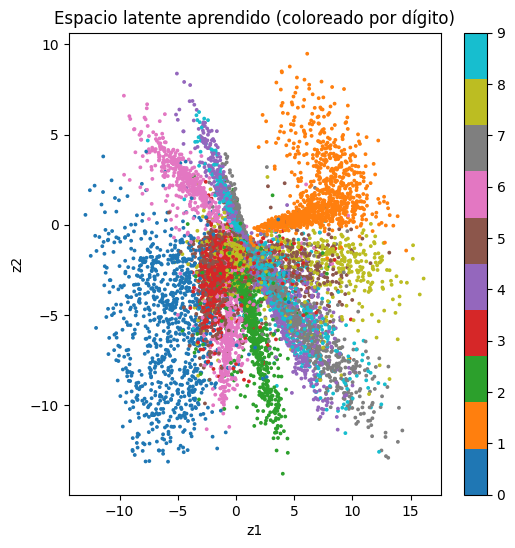

In [ ]:
# Visualizar el espacio latente (2D)
# Importante: las etiquetas se usan SOLO para colorear el gráfico (no para entrenar).

model.eval()
zs = []
ys = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, z = model(x)
        zs.append(z.cpu())
        ys.append(y)

Z = torch.cat(zs, dim=0).numpy()
Y = torch.cat(ys, dim=0).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(Z[:,0], Z[:,1], c=Y, s=3, cmap="tab10")
plt.colorbar()
plt.title("Espacio latente aprendido (coloreado por dígito)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()



## Cierre

Un autoencoder aprende una representación útil **solo si el cuello de botella lo obliga** a conservar estructura y descartar ruido.

**Puente a VAEs (Sesión 10):**
- En autoencoders, el espacio latente no tiene una distribución bien definida.
- En VAEs, forzamos una estructura probabilística para **poder muestrear** y generar.

Pregunta final: **¿Qué falta para poder generar nuevos dígitos de manera controlada?**
